***Méthodes numériques: Module 4***

# Grey Scott model

Nous commencons par importer la librairie numpy, matplotlib et matplotlib.cm qui nous permettra de dessiner des **cartes**.
Ensuite nous définissons tous nos paramètres et nous importons le fichier contenant les données initiales u et v qui se trouve dans le fichier data du même dépôt.

In [1]:
import numpy
from matplotlib import pyplot
import matplotlib.cm as cm
%matplotlib inline

In [2]:
uvinitial = numpy.load('./data/uvinitial.npz')
U = uvinitial['U']
V = uvinitial['V']
print(U,V)

[[ 1.03341932  1.00909902  1.03523907 ...,  1.01236     1.02769296
   1.01185515]
 [ 1.02049366  1.03874603  1.03186003 ...,  1.00917594  1.00648275
   1.01929723]
 [ 1.0297385   1.02874589  1.02488765 ...,  1.0345737   1.00195443
   1.03189674]
 ..., 
 [ 1.03851006  1.01833226  1.00260628 ...,  1.00514165  1.04292736
   1.0090857 ]
 [ 1.03951143  1.0425582   1.03609776 ...,  1.00643229  1.04094253
   1.03869138]
 [ 1.01132752  1.00554757  1.00241105 ...,  1.04435044  1.02683595
   1.01239924]] [[ 0.04286057  0.01747253  0.03235064 ...,  0.0283667   0.03892816
   0.0255146 ]
 [ 0.03567483  0.04898278  0.03607639 ...,  0.02100673  0.0305137
   0.00374435]
 [ 0.04936444  0.0423903   0.00414055 ...,  0.02084643  0.03015715
   0.03085144]
 ..., 
 [ 0.03707045  0.03856759  0.01737007 ...,  0.00421018  0.03256909
   0.00247397]
 [ 0.04781775  0.00190273  0.02729943 ...,  0.02507722  0.0468819
   0.00760259]
 [ 0.01798466  0.02495585  0.04354743 ...,  0.00184759  0.01039884
   0.01832535]]


Le système d'équations différentielles à résoudre s'écrit:


\begin{align}
\frac{\partial u}{\partial t} &= D_u \nabla ^2 u - uv^2 + F(1-u)\\
\frac{\partial v}{\partial t} &= D_v \nabla ^2 v + uv^2 - (F + k)v
\end{align}

## Méthode explicite

Nous allons le discrétiser vers l'avant dans le temps et par un schéma centré dans l'espace (forward-time,centred-space). Nous allons le résoudre par un schéma explicite: la discrétisation dans l'espace s'effectue au temps n:


\begin{align}
\frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}= D_{u}*(\frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{\Delta x^2}+\frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{\Delta y^2})-u_{i,j}^{n}*(v_{i,j}^{n})^2+F(1-u_{i,j}^{n})\\
\frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t}=D_{v}*(\frac{v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}}{\Delta x^2}+\frac{v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}}{\Delta y^2})+u_{i,j}^{n}*(v_{i,j}^{n})^2-F(1+k)v_{i,j}^{n}
\end{align}

On pose ensuite 
\begin{align}
\Delta x^2=\Delta y^2=\delta^2\\
\Delta t= \frac{9}{40}\frac{\delta^2}{\max(D_u, D_v)}
\end{align}

On met tous les termes connus dans le membre de droite et les termes inconnus dans le membre de gauche:

\begin{align}
u_{i,j}^{n+1}=u_{i,j}^{n}+\Delta t(Du*(\frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{\delta^2}+\frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{\delta^2})-u_{i,j}^{n}*(v_{i,j}^{n})^2+F(1-u_{i,j}^{n}))\\
v_{i,j}^{n+1}=v_{i,j}^{n}+\Delta t(Dv*(\frac{v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}}{\delta^2}+\frac{v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}}{\delta^2})+u_{i,j}^{n}*(v_{i,j}^{n})^2-F(1+k)v_{i,j}^{n})
\end{align}
c'est-à-dire:
\begin{align}
u_{i,j}^{n+1}=u_{i,j}^{n}*(1-4\frac{\Delta t*Du}{\delta^2})+\Delta t(Du*(\frac{u_{i+1,j}^{n}+u_{i-1,j}^{n}+u_{i,j+1}^{n}+u_{i,j-1}^{n}}{\delta^2})-u_{i,j}^{n}*(v_{i,j}^{n})^2+F(1-u_{i,j}^{n}))\\
v_{i,j}^{n+1}=v_{i,j}^{n}*(1-4\frac{\Delta t*Dv}{\delta^2})+\Delta t(Dv*(\frac{v_{i+1,j}^{n}+v_{i-1,j}^{n}+v_{i,j+1}^{n}+v_{i,j-1}^{n}}{\delta^2})+u_{i,j}^{n}*(v_{i,j}^{n})^2-F(1+k)v_{i,j}^{n})
\end{align}

### Paramètres:

In [26]:
def greyscott(u0,v0,CI,nt,dt):
    Du=CI[0]
    Dv=CI[1]
    F=CI[2]
    k=CI[3]
    ucopy=u0.copy()
    vcopy=v0.copy()
    for j in range (nt):
        uk=ucopy.copy()
        vk=vcopy.copy()
        ucopy[1:-1,1:-1]=uk[1:-1,1:-1]*(1-4*dt*Du/dh**2)+dt*Du*(uk[2:,1:-1]+uk[:-2,1:-1]+uk[1:-1,2:]+uk[1:-1,:-2])/(dh**2)\
                        -dt*uk[1:-1,1:-1]*(vk[1:-1,1:-1])**2+dt*F*(1-uk[1:-1,1:-1])
        vcopy[1:-1,1:-1]=vk[1:-1,1:-1]*(1-4*dt*Dv/dh**2)+dt*Dv*(vk[2:,1:-1]+vk[:-2,1:-1]+vk[1:-1,2:]+vk[1:-1,:-2])/(dh**2)\
                        +dt*uk[1:-1,1:-1]*(vk[1:-1,1:-1])**2-dt*F*(1+k)*vk[1:-1,1:-1]
        #conditions de Neumann:
        ucopy[:,0]=ucopy[:,1]
        ucopy[0,:]=ucopy[1,:]
        ucopy[:,191]=ucopy[:,190]
        ucopy[191,:]=ucopy[190,:]
        vcopy[:,0]=vcopy[:,1]
        vcopy[0,:]=vcopy[1,:]
        vcopy[:,191]=vcopy[:,190]
        vcopy[191,:]=vcopy[190,:]
        
    return (ucopy,vcopy)

**Paramètres**

In [27]:
n = 192
I1=numpy.array([0.00016, 0.00008, 0.035, 0.065]) # Bacteria 1 
dh = 5/(n-1) #delta
T = 8000

In [28]:
def dtandnt(CI):
    dt = .9 * dh**2 / (4*max(CI[0],CI[1]))
    nt=int(T/dt)
    return (dt,nt)

In [29]:
def solandmap(CI):
    sol=greyscott(U,V,CI,dtandnt(CI)[1],dtandnt(CI)[0])
    fig = pyplot.figure(figsize=(8,5))
    pyplot.subplot(121)
    pyplot.imshow(sol[0], cmap = cm.RdBu)
    pyplot.xticks([]), pyplot.yticks([]);
    pyplot.subplot(122)
    pyplot.imshow(sol[1], cmap = cm.RdBu)
    pyplot.xticks([]), pyplot.yticks([]);

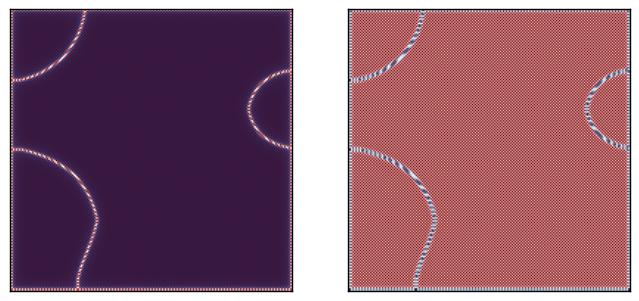

In [30]:
solandmap(I1)

**Autres paramètres**

In [31]:
I2=numpy.array([0.00014, 0.00006, 0.035, 0.065]) # Bacteria 2
I3=numpy.array([0.00016, 0.00008, 0.060, 0.062]) # Coral
I4=numpy.array([0.00019, 0.00005, 0.060, 0.062]) # Fingerprint
I5=numpy.array([0.00010, 0.00010, 0.018, 0.050]) # Spirals
I6=numpy.array([0.00012, 0.00008, 0.020, 0.050]) # Spirals Dense
I7=numpy.array([0.00010, 0.00016, 0.020, 0.050]) # Spirals Fast
I8=numpy.array([0.00016, 0.00008, 0.020, 0.055]) # Unstable
I9=numpy.array([0.00016, 0.00008, 0.050, 0.065]) # Worms 1
I10=numpy.array([0.00016, 0.00008, 0.054, 0.063]) # Worms 2
I11=numpy.array([0.00016, 0.00008, 0.035, 0.060]) # Zebrafish

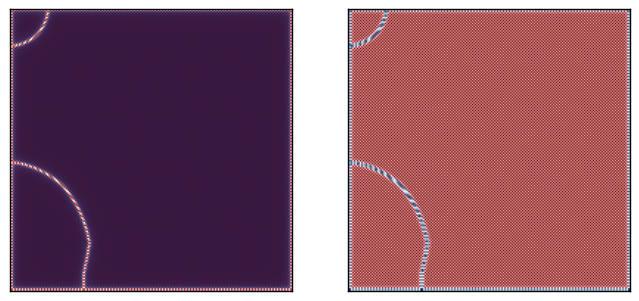

In [32]:
solandmap(I3)

## Méthode implicite

Cette fois-ci nous utilisons la méthode implicite: la discrétisation dans l'espace s'effectue au temps n+1:
\begin{align}
\frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}= D_{u}*(\frac{u_{i+1,j}^{n+1}-2u_{i,j}^{n+1}+u_{i-1,j}^{n+1}}{\Delta x^2}+\frac{u_{i,j+1}^{n+1}-2u_{i,j}^{n+1}+u_{i,j-1}^{n+1}}{\Delta y^2})-u_{i,j}^{n}*(v_{i,j}^{n})^2+F(1-u_{i,j}^{n})\\
\frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t}=D_{v}*(\frac{v_{i+1,j}^{n+1}-2v_{i,j}^{n+1}+v_{i-1,j}^{n+1}}{\Delta x^2}+\frac{v_{i,j+1}^{n+1}-2v_{i,j}^{n+1}+v_{i,j-1}^{n+1}}{\Delta y^2})+u_{i,j}^{n}*(v_{i,j}^{n})^2-F(1+k)v_{i,j}^{n})
\end{align}
